# Q3
Pseudocode:
1. Define functions for x and y components of acceleration as found in part a) for each particle.
2. Instantiate variables N = 1000 steps and h = 0.001 step size, as well as initial conditions for velocity components for each particle (in this case all 0). Let number of particles be an input parameter of the function we are defining. This way we can model any number of particles that is a perfect square.
3. Definine initial conditions for position components as specified. In this case, evenly spaced in a grid of size sqrt of number of particles. 
4. Preallocate memory to an empty arrays of size number of particles by number of iterations by 2 to later store x and y components for position and velocity for each particle at each time step. 
5. Store initial conditions for velocity and position components in the 0th time index in their respective arrays for both x and y components.
6.
7. Implement equations 8-11 component-wise from lab manual with acceleration components mentioned in step 1 as the components of $\vec{f}$.
8. In a for-loop from 2 to N-1 (since we index from zero this corresponds to N iterations in total) update values for trajectory and velocity components according to the series of equations 8-11 in the lab manual (Verlet method) and store the values at each iteration in the appropriate array that we instantiated in step 4. 


In [1]:
import numpy as np

In [2]:
def Potential(r):
    return 4*(r**(-12) - r**(-6))
def Kinetic(vx, vy):
    return 0.5*(vx**2 + vy**2)

In [3]:
# acceleration
def fx_ij(xi, xj, yi, yj):
    '''
    Function f_ij: Gives the x comp of acceleration experienced by particle i due to
    Lennard-Jones potential wrt particle j.  
    '''
    r = np.sqrt((xj- xi)**2 + (yj - yi)**2)  # separation distance
    return 24 * (xj - xi) * r**(-4) * (1 - 2 * r**(-6))
    
def fy_ij(xi, xj, yi, yj):
    '''
    Function f_ij: Gives the y comp of acceleration experienced by particle i due to
    Lennard-Jones potential wrt particle j.  
    '''
    r = np.sqrt((xj- xi)**2 + (yj - yi)**2)  # separation distance
    return 24 * (yj - yi) * r**(-4) * (1 - 2 * r**(-6))
    
def R(xi, xj, yi, yj):
    return np.sqrt((xj- xi)**2 + (yj - yi)**2)

In [18]:
def Periodic_Force(rx1, rx2, ry1, ry2):
    # First Replicated opther 8 tiles. 
    Lx = 4.0    # X component of momentum
    Ly = 4.0    # Y component of momentum
    x_acceleration = 0
    y_acceleration = 0
    # replicate the positions
    replicated_positions = np.zeros([9,4])
    for ix in range(3):
        replicated_positions[ix*3:3+ix*3,0] = rx1 + ix*Lx - Lx
        replicated_positions[ix*3:3+ix*3,1] = rx2 + ix*Lx - Lx
    for jy in range(3):
            replicated_positions[jy::3,2] = ry1 + jy*Ly - Ly
            replicated_positions[jy::3,3] = ry2 + jy*Ly - Ly
    #print(replicated_positions)
    num_particles = len(replicated_positions)
    # calculate acceosileration
    for index in range(2):
        for i in range(num_particles):
        #need to sum up the interactions on each particle from all the others
            x_acceleration += fx_ij(replicated_positions[4,0],replicated_positions[i,index], \
                replicated_positions[4,2],replicated_positions[i,2+index])
            y_acceleration += fx_ij(replicated_positions[4,0],replicated_positions[i,0], \
                    replicated_positions[5,2],replicated_positions[i,2+index])
    for index in range(2):
        for i in range(num_particles):
                #need to sum up the interactions on each particle from all the others
            x_acceleration += fx_ij(replicated_positions[4,1],replicated_positions[i,index], \
                    replicated_positions[4,3],replicated_positions[i,2+index])
            y_acceleration += fx_ij(replicated_positions[4,1],replicated_positions[i,index], \
                    replicated_positions[4,3],replicated_positions[i,2+index])
    return x_acceleration, y_acceleration

In [53]:
def Periodic_Position(rx,ry_float):
    Lx = 4.0    # X component of momentum
    Ly = 4.0    # Y component of momentum
    rx_mod = np.mod(f_rx, Lx)
    ry_mod = np.mod(f_ry, Ly)
    return rx_mod, ry_mod

In [54]:
def doVerlet(num_particles, periodic = False):
    '''
    Function: DoVerlet: This function performs the Verlet algorithim 
    in order to calculate the position of two particles. 
    Input: A length N array containing ordered pairs [x,y] (length 2 arrays) indicating
    initial conditions for each particle
    ''' 
    N = 1000 #number of iterations
    h = 0.001 #time step
    
    # Initial Conditions
    Lx = 4.0    # X component of momentum
    Ly = 4.0    # Y component of momentum
    dx = Lx/np.sqrt(num_particles)
    dy = Ly/np.sqrt(num_particles)
    x_grid = np.arange(dx/2, Lx, dx)
    y_grid = np.arange(dy/2, Ly, dy)
    xx_grid, yy_grid = np.meshgrid(x_grid, y_grid)
    x_initial = xx_grid.flatten()
    y_initial = yy_grid.flatten()
    
    #initial rest condition
    v_i = 0.0
    
    #preallocate memory for position velocity, v_prep (ie v(t+h/2))
    r = np.zeros([num_particles, N, 2])
    v = np.zeros([num_particles, N, 2])
    v_prep = np.zeros([num_particles,2])
    
    #set IC
    r[:,0,0] = x_initial
    r[:,0,1] = y_initial
    v[:,0,:] = v_i
    
    #eq 7
    #variables with _prep suffix get updated at each iteration and represent
    #v(t+h/2) in Verlet algorithm (eq 8 - 11) in lab manual
    
    #arrays for storing acceleration due to interaction from each particle
    fx = np.zeros(num_particles)
    fy = np.zeros(num_particles)

    #let's get the first v_prep's using equation 7
    Energy = np.zeros(N)
    Pot = np.zeros(N)
    Kin = np.zeros(N)
    for i in range(num_particles):
        for j in range(num_particles):
            if j != i:
                #print(i,j)
                #need to sum up the interactions on each particle from all the others
                fx[i] += fx_ij(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1])
                fy[i] += fy_ij(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1])
                if periodic == True:
                    periodic_x_force,periodic_y_force \
                    = Periodic_Force(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1])
                    fx[i] = periodic_x_force
                    fy[i] = periodic_y_force
                #potential energy
                Pot[0] += Potential(R(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1]))
                #print(R(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1]), 'seperation')
                #print(Potential((R(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1]))), 'potential')
        #kinetic energy
        Kin[0] += Kinetic(v[i, 0, 0], v[i, 0, 1])
        v_prep[i, 0] = v[i, 0, 0] + 0.5 * h * fx[i] #divide by 2 to account for double counting
        v_prep[i, 1] = v[i, 0, 1] + 0.5 * h * fy[i] #divide by 2 to account for double counting
    #total energy for t = 0
    Energy[0] = Kin[0] + Pot[0]/2 #divide by 2 to account for double counting
    
    #now that we've 'prepped' the system we can begin iterating
    
    
    #print(Kin[0], Pot[0], 'potential energy')
    for i in range(1,N):
        for j in range(num_particles): #need to update each particle at each time step 
            #eq 8
            r[j, i, 0] = r[j, i-1, 0] + h * v_prep[j, 0] #x
            r[j, i, 1] = r[j, i-1, 1] + h * v_prep[j, 1] #y
            if periodic == True:
                r[j, i, 0],r[j, i, 1] = Periodic_Position(r[j, i, 0],r[j, i, 1])
        for j in range(num_particles):
            #need to sum up the interactions on each particle from all the others
            fx = np.zeros(num_particles)
            fy = np.zeros(num_particles) 
            for k in range(num_particles): 
                if k != j:
                    #print(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1], 'xi','xj','yi','yj')
                    fx[j] += fx_ij(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1])
                    fy[j] += fy_ij(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1])
                    if periodic == True:
                        periodic_x_force,periodic_y_force \
                            = Periodic_Force(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1])
                        fx[i] = periodic_x_force
                        fy[i] = periodic_y_force
                    #print(R(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1]), 'R')
                    Pot[i] += Potential(R(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1]))
                    #print(Pot[i])
            #print(Kin[i])
            #eq 9 and 10 combined
            v[j, i, 0] = v_prep[j, 0] + 0.5 * h * fx[j]
            v[j, i, 1] = v_prep[j, 1] + 0.5 * h * fy[j] 
            #print(v[j,i,1], i, j)
            #eq 9 and 11 combined (getting v_prep's for next iteration)
            v_prep[j, 0] += h * fx[j]
            v_prep[j, 1] += h * fy[j]
        for j in range(num_particles):
            Kin[i] += Kinetic(v[j, i, 0], v[j, i, 1])

        #print(Kin[i], Pot[i])

        Energy[i] = Kin[i] + Pot[i]/2 #divide by 2 to account for double counting
        #print(Kin[i], Pot[i])
        #print(Energy[i])
    t = np.linspace(0,h*(N-1),N)
    return v, r, t, Energy, Kin, Pot

In [55]:
num_particles = 16
v, r, t, Energy, Kin, Pot = doVerlet(num_particles)

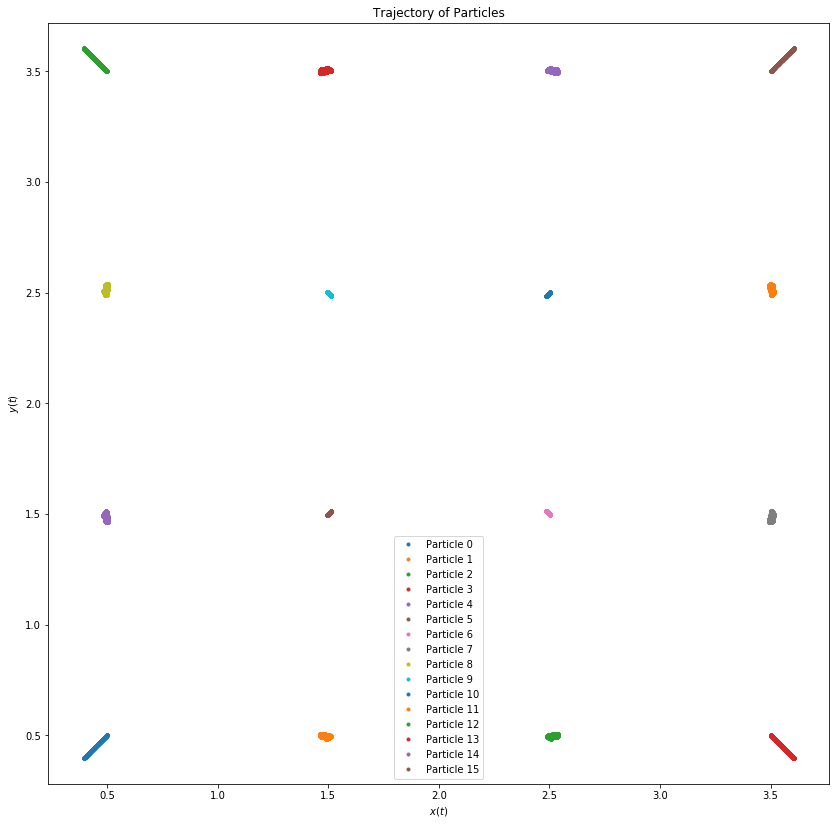

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize = (14,14))
plt.title('Trajectory of Particles')
plt.xlabel('$x(t)$')
plt.ylabel('$y(t)$')
for i in range(num_particles):
    lb = 'Particle '+str(i)
    plt.plot(r[i,:,0], r[i,:,1], '.', label = lb)
plt.legend()
plt.axis('equal')
plt.show()

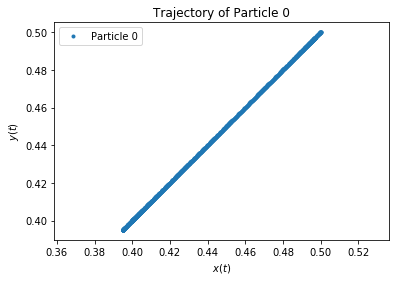

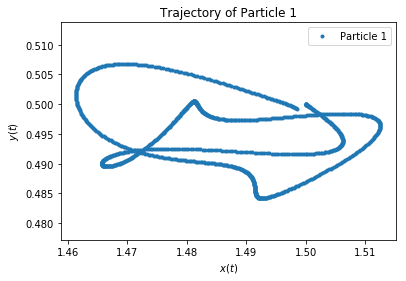

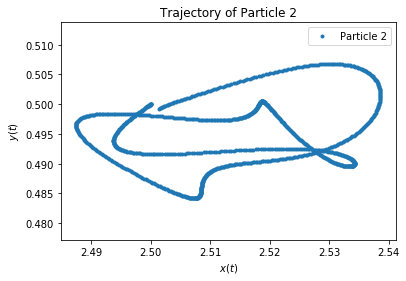

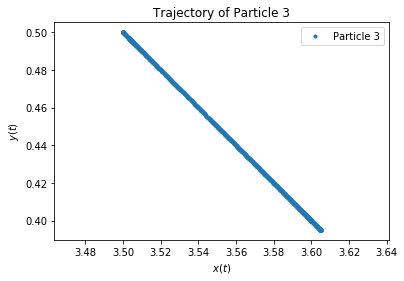

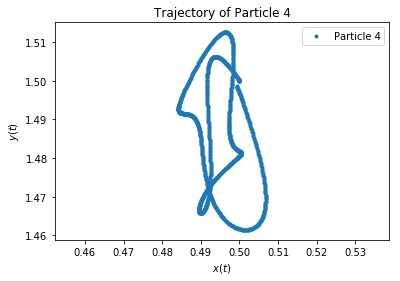

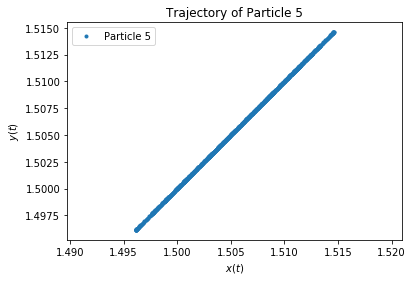

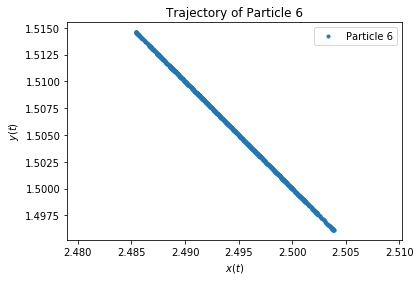

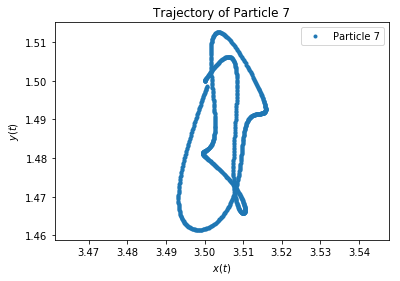

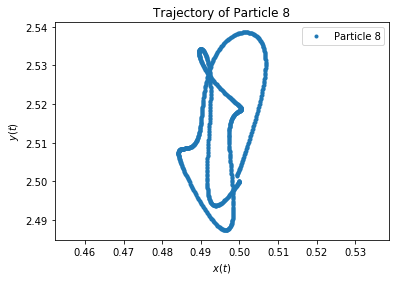

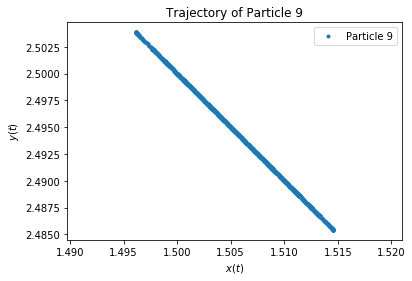

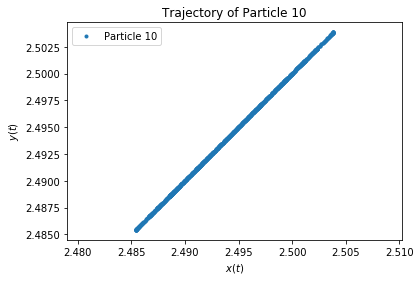

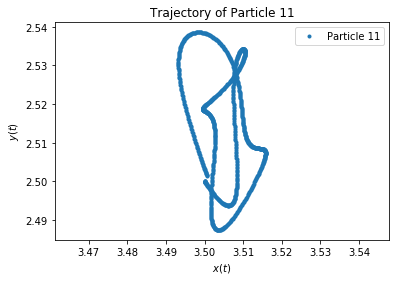

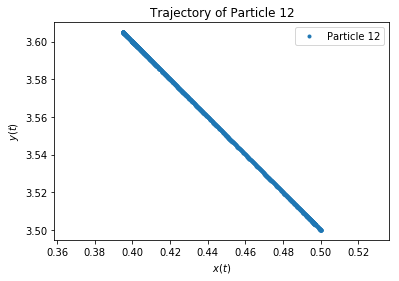

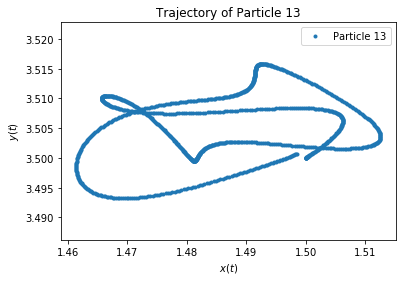

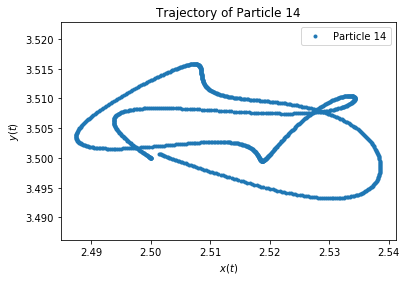

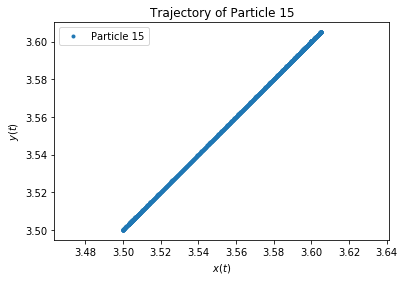

In [57]:
for i in range(num_particles):
    plt.figure()
    plt.title('Trajectory of Particle '+str(i))
    plt.xlabel('$x(t)$')
    plt.ylabel('$y(t)$')
    lb = 'Particle '+str(i)
    plt.plot(r[i,:,0], r[i,:,1], '.', label = lb)
    plt.legend()
    plt.axis('equal')
    plt.show()

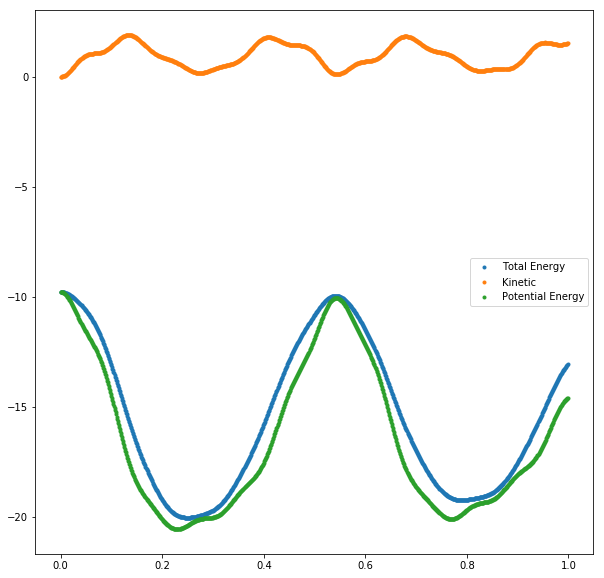

In [58]:
plt.figure(figsize = (10,10))
plt.plot(t, Energy, '.', label = 'Total Energy')
plt.plot(t, Kin, '.', label = 'Kinetic')
plt.plot(t, Pot/2, '.', label = 'Potential Energy')
plt.legend()

In [59]:
KE = np.zeros(1000)
for i in range(1000):
    Kstep = np.zeros(16)
    for j in range(16):
        Kstep[j] = Kinetic(v[j, i, 0], v[j, i, 1])
    KE[i] = np.sum(Kstep)
    
PE = np.zeros(1000)
for i in range(1000):
    Pstep = np.zeros(16)
    for j in range(16):
        for k in range(16):
            if j != k:
                Pstep[j] = Potential(R(r[j,i,0], r[k,i,0],r[j,i,1],r[k,i,1]))
    PE[i] = np.sum(Pstep)/2
Total = PE + KE

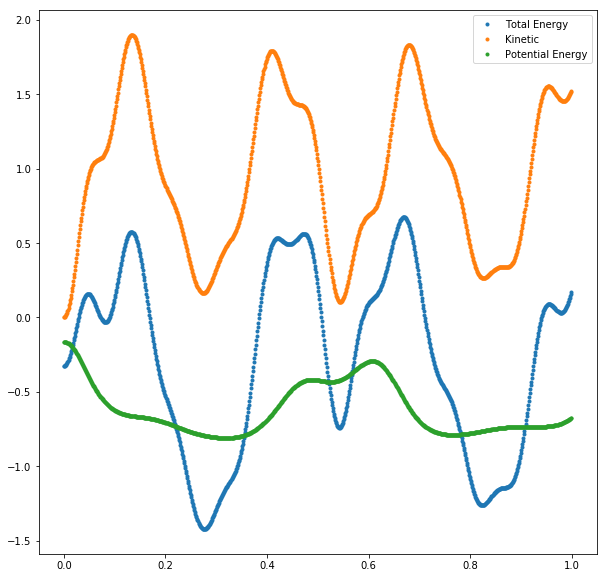

In [60]:
plt.figure(figsize = (10,10))
plt.plot(t, Total, '.', label = 'Total Energy')
plt.plot(t, KE, '.', label = 'Kinetic')
#plt.plot(t, Kin, '.', label = 'Kin Verlet')
#plt.plot(t, Pot, '.', label = 'Pot Verlet')
plt.plot(t, PE/2, '.', label = 'Potential Energy')
plt.legend()

In [61]:
print(max(Total),'max')
print(min(Total),'min')
print(np.mean(Total),'mean')
print(Total[0],'inititial')

0.6750461326013535 max
-1.4223579746646189 min
-0.2826460767664461 mean
-0.3275542124131538 inititial


In [62]:
100*(max(Total) - min(Total))/Total[0]

-640.3227398035884

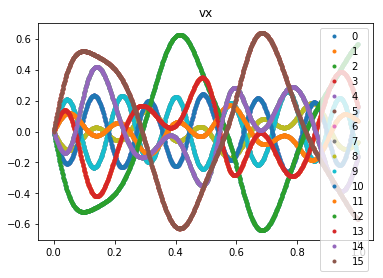

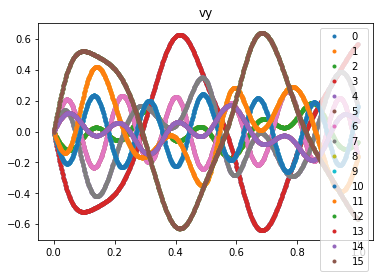

In [63]:
plt.figure()
plt.title('vx')
for i in range(16):
    plt.plot(t,v[i,:,0],'.', label = str(i))
plt.legend()
plt.figure()
plt.title('vy')
for i in range(16):
    plt.plot(t,v[i,:,1],'.', label = str(i))
plt.legend()

In [64]:
vp, rp, tp, Energyp, Kinp, Potp = doVerlet(num_particles, periodic = True)

C:\Users\brayd\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\brayd\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


NameError: name 'f_rx' is not defined